# Cuk Converter State Space Model

In [36]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca
import sympy as sym

from IPython.display import display, Math

import sys
sys.path.append('../../../')

from utils.lcapy_utils import *


circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    style="american",
    draw_nodes=True,
    label_nodes=False,
    label_ids=False,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

The Cuk Converter:
Stretch conflict 0.65 vs 0.35 in vertical graph for M1 between nodes (0, 0_1, 0_2, nC22, nP21) and (_gate), due to incompatible sizes


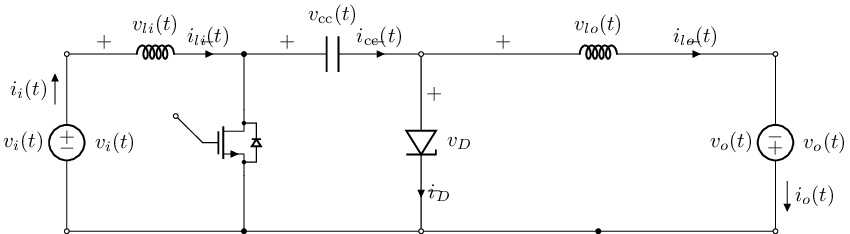

Operation step 1: Switch is ON


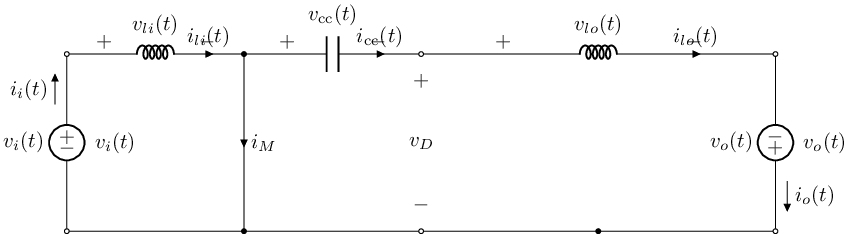

<IPython.core.display.Math object>

Operation step 2: Switch is OFF


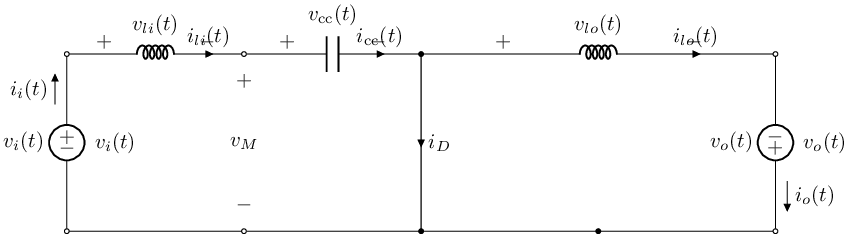

<IPython.core.display.Math object>

Averaged Large-Signal Model:


<IPython.core.display.Math object>

Averaged Small-Signal Model - First-order linearization:


<IPython.core.display.Math object>

In [37]:
class cuk:
    def netlist(state: bool = -1):
        return "\n".join(
            filter(
                None,
                [
                    cuk._input(),
                    cuk._commutation_cell(state),
                    cuk._output(),
                ],
            )
        )

    def _input():
        source = "\n".join(
            [
                "P1 0 i; up",
                # "W i nC11; right",
                "Vi i 0 {v_i(t)}; down, l={v_{i}(t)}, f={i_{i}(t)}, v={v_{i}(t)}",
                # "Ii i 0 {i_Ii(t)}; down, l={i_{i}(t)}, v={v_{i}(t)}",
            ]
        )
        inductor = "L1 i M; right, i={i_{li}(t)}, v={v_{li}(t)}"
        ground = "\n".join(
            [
                "W  0    0_1; right",
            ]
        )
        return "\n".join(filter(None, [source, inductor, ground]))

    def _commutation_cell(state: bool = -1):
        capacitor = "C2 M D; right, i={i_{cc}(t)}, v={v_{cc}(t)}"
        if state == -1:
            switches = "\n".join(
                [
                    "M1 M _gate 0_1 nmos; nosim, right=.7, bodydiode, arrowmos, i={i_{M}}, v={v_{M}}"
                    + ("" if state == -1 else ", invisible"),
                    "D1 D 0_2 schottky; nosim, down, i={i_{D}}, v={v_{D}}"
                    + ("" if state == -1 else ", invisible"),
                ]
            )
        else:
            switches = ""

        ground = "W  0_1 0_2; right"
        if state:
            switches_for_simulation = "\n".join(
                [
                    "W  M 0_1; down, i={i_{M}}"
                    + (", invisible" if state == -1 else ""),
                    "P3 D 0_2; down, v={v_{D}}"
                    + (", invisible" if state == -1 else ""),
                ]
            )
        else:
            switches_for_simulation = "\n".join(
                [
                    "P3 M 0_1; down, v={v_{M}}"
                    + (", invisible" if state == -1 else ""),
                    "W  D 0_2; down, i={i_{D}}"
                    + (", invisible" if state == -1 else ""),
                ]
            )

        return "\n".join(
            filter(None, [capacitor, switches, switches_for_simulation, ground])
        )

    def _output():
        load = "\n".join(
            [
                "P2 o nP21; down",
                "Vo nP21 o {v_o(t)}; up, l={v_{o}(t)}, f={i_{o}(t)}, v={v_{o}(t)}",
                # "Io nP21 o {i_Io(t)}; up, l={v_{o}(t)}, f={i_{o}(t)}, v={v_{o}(t)}",
            ]
        )
        inductor = "L2 D o; right, i={i_{lo}(t)}, v={v_{lo}(t)}"
        ground = "\n".join(
            [
                "W  nC22 nP21; right",
                "W  0_2  nC22; right",
            ]
        )

        return "\n".join(filter(None, [load, inductor, ground]))

    def describe():
        print("The Cuk Converter:")
        cct = lca.Circuit(netlist=cuk.netlist()).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct.draw(**circuit_draw_params)

        print("Operation step 1: Switch is ON")
        cct_on = lca.Circuit(netlist=cuk.netlist(True)).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct_on.draw(**circuit_draw_params)

        outputs = {
            'node_voltages': [],
            'branch_currents': ['Vi', 'Vo'],
        }
        # outputs = {} # Enable all outputs, for debugging

        ss_on = cct_on.ss
        ss_on = lca.StateSpace.from_circuit(cct_on, **outputs)
        display_lcapy_ss(ss_on)

        print("Operation step 2: Switch is OFF")
        cct_off = lca.Circuit(netlist=cuk.netlist(False)).subs({}) # <- FIXME: workaround for lcapy's issue #74
        cct_off.draw(**circuit_draw_params)

        ss_off = cct_off.ss
        ss_off = lca.StateSpace.from_circuit(cct_off, **outputs)
        display_lcapy_ss(ss_off)

        print("Averaged Large-Signal Model:")
        ss_lsm = get_averaged_large_signal_model(ss_on, ss_off)
        display_lcapy_ss(ss_lsm)

        print("Averaged Small-Signal Model - First-order linearization:")
        ss_ssm = get_averaged_small_signal_model(ss_on, ss_off)
        display_lcapy_ss(ss_ssm)

        return cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm


cct, cct_on, cct_off, ss_on, ss_off, ss_lsm, ss_ssm = cuk.describe()

---

In [38]:
values = {
    'C1': 1e-6,
    'C2': 10e-6,
    'L1': 100e-6,
    'L2': 100e-6,
    ss_lsm.A[2].args[2].args[1].args[1]: 0.5,
}
values

{'C1': 1e-06, 'C2': 1e-05, 'L1': 0.0001, 'L2': 0.0001, d(t): 0.5}

## State Space Simulation

In [39]:
import control
import numpy as np
import pandas as pd

def lcapy_statespace_to_pythoncontrol(ss: lca.StateSpace, values, name=None) -> control.StateSpace:

    ss = ss.subs(values)

    states = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss.x]
    outputs = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss.y]
    inputs = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss.u]

    return control.StateSpace(
        np.array(ss.A.expr, dtype=float),
        np.array(ss.B.expr, dtype=float),
        np.array(ss.C.expr, dtype=float),
        np.array(ss.D.expr, dtype=float),
        name=name,
        states=states,
        inputs=inputs,
        outputs=outputs,
    )

ss = lcapy_statespace_to_pythoncontrol(ss_lsm, values=values, name='mppt_p_outwer')
ss.__dict__

{'A': array([[    0.,     0., -5000.],
        [    0.,     0., -5000.],
        [50000., 50000.,     0.]]),
 'B': array([[10000.,     0.],
        [    0., 10000.],
        [    0.,     0.]]),
 'C': array([[-1.,  0.,  0.],
        [ 0., -1.,  0.]]),
 'D': array([[0., 0.],
        [0., 0.]]),
 'name': 'mppt_p_outwer',
 'ninputs': 2,
 'input_index': {'v_i': 0, 'v_o': 1},
 'noutputs': 2,
 'output_index': {'i_Vi': 0, 'i_Vo': 1},
 'nstates': 3,
 'state_index': {'i_L1': 0, 'i_L2': 1, 'v_C2': 2},
 'dt': 0,
 'params': {},
 'updfcn': <function control.statesp.StateSpace.__init__.<locals>.<lambda>(t, x, u, params)>,
 'outfcn': <function control.statesp.StateSpace.__init__.<locals>.<lambda>(t, x, u, params)>,
 '_current_params': {}}

array([<Axes: xlabel='t'>, <Axes: xlabel='t'>], dtype=object)

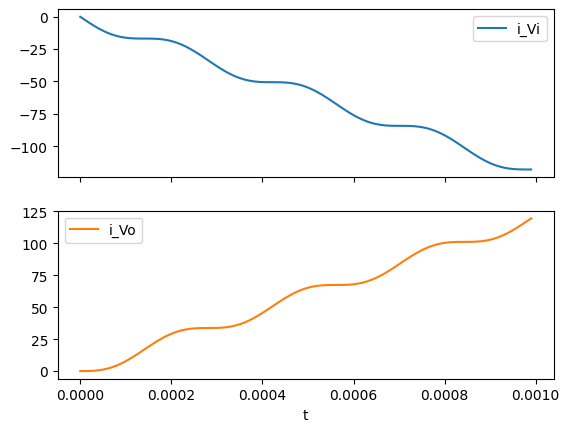

In [44]:
u_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.u]
x_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.x]
y_names = [str(expr.name).replace('\hat{', '').replace('}', '') for expr in ss_lsm.y]

d = 0.5
vi = 24
vo = vi * (d / (1 - d))
length = 100
df = pd.DataFrame(np.array([
    vo*np.ones(length),
    vi*np.zeros(length),
]).T, index=np.linspace(0, 1000e-6, length, endpoint=False), columns=[*u_names])

# Prepare the inputs signals
t = df.index.to_numpy().T
U = df[[*u_names]].to_numpy().T
# display(df[[*u_names]])

# Simulate applying the inputs signals
t, yout, xout = control.forced_response(ss, t, U, return_x=True, squeeze=True)

# Gather the outputs and states signals
df_xout = pd.DataFrame(xout.T, index=t.T, columns=[*x_names])
df_yout = pd.DataFrame(yout.T, index=t.T, columns=[*y_names])
df_xout.index.rename('t', inplace=True)
df_yout.index.rename('t', inplace=True)
# display(df_xout)
# display(df_yout)

df_yout.plot(subplots=True)

In [77]:
import pvlib
import control as ct

class SolarPanel:
    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        Iph_STC = params['pv_Iph_STC']
        I0_STC = params['pv_I0_STC']
        Rs_STC = params['pv_Rs_STC']
        Rp_STC = params['pv_Rp_STC']
        a_STC = params['pv_a_STC']
        Asc = params['pv_Asc']
        Eg_STC = params['pv_Eg_STC']
        dEgdT_STC = params['pv_dEgdT_STC']
        Tc_STC = params['pv_Tc_STC']
        G_STC = params['pvs_g_STC']
        alpha = params['pv_th_alpha']  # The light absorptance of the module
        u0 = params['pv_th_u0']  # Combined heat transfer coefficient at zero wind speed [(W/m^2)/C]
        u1 = params['pv_th_u1']  # Influence of wind speed on combined heat transfer coefficient [(W/m^2)/ºC/(m/s)]

        # Inputs
        Ipv = u[0] # Panel current [A]
        G = u[1]  # Total incident irradiance [W/m^2]
        Ta = u[2]  # Ambient dry bulb temperature [ºC]
        Sw = u[3]  # Wind speed at a height of 10 meters [m/s]

        # About faiman_rad: https://datahub.duramat.org/dataset/module-temperature/resource/40f2b3ac-8415-4664-b622-c1b770c89799
        Tc = pvlib.temperature.faiman_rad(poa_global=G, temp_air=Ta, wind_speed=Sw, ir_down=None, u0=u0, u1=u1, sky_view=1.0, emissivity=alpha)

        Iph, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
            effective_irradiance=G, temp_cell=Tc, alpha_sc=Asc, a_ref=a_STC, I_L_ref=Iph_STC, I_o_ref=I0_STC, R_sh_ref=Rp_STC, R_s=Rs_STC, EgRef=Eg_STC, dEgdT=dEgdT_STC, irrad_ref=G_STC, temp_ref=Tc_STC)

        Vpv = np.clip(pvlib.pvsystem.i_from_v(Ipv, photocurrent=Iph, saturation_current=I0, resistance_series=Rs, resistance_shunt=Rsh, nNsVth=nNsVth, method='lambertw'), a_min=0, a_max=None)

        return Vpv, Tc

    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            None,
            cls._outputs,
            name="solar_panel",
            # dt=params['dt'],
            states=None,
            inputs=('I', 'G', 'Ta', 'Sw'),
            outputs=('V', 'Tc'),
            params=params,
        )

generation_params = {
    'pv_Iph_STC': 8.738959068154207,
    'pv_I0_STC': 2.1982994421060667e-10,
    'pv_Rs_STC': 0.1853708789540368,
    'pv_Rp_STC': 833.8269824839556,
    'pv_a_STC': 1.529627874530232,
    'pv_Asc': 0.0053879999999999996,
    'pv_Eg_STC': 1.121,
    'pv_dEgdT_STC': -0.0002677,
    'pv_Tc_STC': 25,
    'pvs_g_STC': 1000,
    'pv_th_alpha': 0.88,
    'pv_th_u0': 25.0,
    'pv_th_u1': 6.84,
    'mppt_eta': 0.9303414194668972,
    'dt': 1,
}

SolarPanel.build(generation_params).__dict__

{'name': 'solar_panel',
 'ninputs': 4,
 'input_index': {'I': 0, 'G': 1, 'Ta': 2, 'Sw': 3},
 'noutputs': 2,
 'output_index': {'V': 0, 'Tc': 1},
 'nstates': 0,
 'state_index': {},
 'dt': 0,
 'params': {'pv_Iph_STC': 8.738959068154207,
  'pv_I0_STC': 2.1982994421060667e-10,
  'pv_Rs_STC': 0.1853708789540368,
  'pv_Rp_STC': 833.8269824839556,
  'pv_a_STC': 1.529627874530232,
  'pv_Asc': 0.0053879999999999996,
  'pv_Eg_STC': 1.121,
  'pv_dEgdT_STC': -0.0002677,
  'pv_Tc_STC': 25,
  'pvs_g_STC': 1000,
  'pv_th_alpha': 0.88,
  'pv_th_u0': 25.0,
  'pv_th_u1': 6.84,
  'mppt_eta': 0.9303414194668972,
  'dt': 1},
 'updfcn': None,
 'outfcn': <bound method SolarPanel._outputs of <class '__main__.SolarPanel'>>,
 '_current_params': {'pv_Iph_STC': 8.738959068154207,
  'pv_I0_STC': 2.1982994421060667e-10,
  'pv_Rs_STC': 0.1853708789540368,
  'pv_Rp_STC': 833.8269824839556,
  'pv_a_STC': 1.529627874530232,
  'pv_Asc': 0.0053879999999999996,
  'pv_Eg_STC': 1.121,
  'pv_dEgdT_STC': -0.0002677,
  'pv_Tc_ST

In [82]:
class MPPT:
    @classmethod
    def build(cls, params: dict):
        ss = ss_lsm.subs(values)

        sys = control.StateSpace(
            np.array(ss.A.expr, dtype=float),
            np.array(ss.B.expr, dtype=float),
            np.array(ss.C.expr, dtype=float),
            np.array(ss.D.expr, dtype=float),
            name="mppt",
            states=("I_L1", "I_L2", 'I_C2'),
            inputs=("Vi", "Vo"),
            outputs=("Ii", "Io"),
        )#.sample(Ts=params['dt'], copy_names=True)
        # sys.name = "mppt"

        return sys

MPPT.build(generation_params)

StateSpace(array([[    0.,     0., -5000.],
       [    0.,     0., -5000.],
       [50000., 50000.,     0.]]), array([[10000.,     0.],
       [    0., 10000.],
       [    0.,     0.]]), array([[-1.,  0.,  0.],
       [ 0., -1.,  0.]]), array([[0., 0.],
       [0., 0.]]))

In [85]:
class Generation:
    @classmethod
    def build(cls, params: dict):
        return ct.interconnect(
            [
                SolarPanel.build(params),
                MPPT.build(params),
            ],
            name='generation',
            # dt=params['dt'],
            connections=(
                ['solar_panel.I', 'mppt.Ii'],
                ['mppt.Vi', 'solar_panel.V'],
            ),
            inplist=['solar_panel.G', 'solar_panel.Ta', 'solar_panel.Sw', 'mppt.Vo'],
            inputs=['G', 'Ta', 'Sw', 'Vo'],
            outlist=['mppt.Ii', 'mppt.Vi', 'mppt.Io', 'solar_panel.Tc'],
            outputs=['Ii', 'Vi', 'Io', 'Tc'],
            params=params,
        )

Generation.build(generation_params)

<InterconnectedSystem:generation:['G', 'Ta', 'Sw', 'Vo']->['Ii', 'Vi', 'Io', 'Tc']>

In [86]:
generation = Generation.build(generation_params)
_generation = generation
x0 = [0, 0, 0, 0]
u0 = [500, 40, 1, -36]

# generation = ct.linearize(generation, x0, u0)
generation.inputs = _generation.input_labels
generation.states = _generation.state_labels
generation.outputs = _generation.output_labels
# generation = generation.sample(Ts=1, method='bilinear', copy_names=True)
display(generation)

<InterconnectedSystem:generation:['G', 'Ta', 'Sw', 'Vo']->['Ii', 'Vi', 'Io', 'Tc']>

In [87]:
from pytz import timezone
import vaex

tzinfo = timezone("America/Sao_Paulo")
renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_dt',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,4)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,4)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,4)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,4)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}

# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')

In [88]:
# df = dfa.copy(deep=True)#.resample('30min').mean()
df = df.iloc[:10]

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'air_t', 'wind_v', 'batt_v']].to_numpy().T

# generation = Generation.build(generation_params)

X0 = np.zeros(generation.nstates)

res = ct.input_output_response(generation, T=T, U=U, X0=X0, method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,7));

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/pvlib/singlediode.py:752: RuntimeWarning: overflow encountered in exp
  np.exp((Rs[idx_p] * (IL[idx_p] + I0[idx_p]) + V[idx_p]) /


array([<Axes: xlabel='timestamp'>, <Axes: xlabel='timestamp'>,
       <Axes: xlabel='timestamp'>], dtype=object)

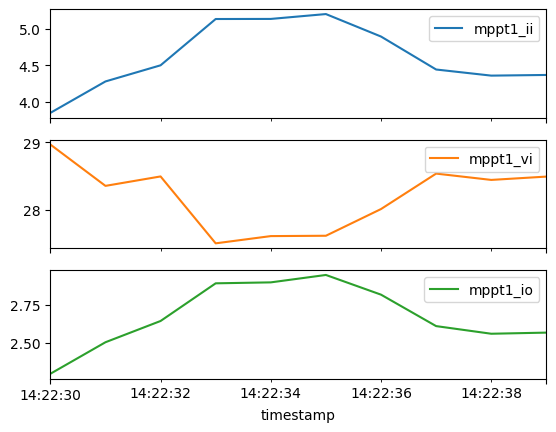

In [ ]:
df[['mppt1_ii', 'mppt1_vi', 'mppt1_io']].plot(subplots=True)